In [1]:
%load_ext autotime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import time
import simfin as sf

from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet

from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

time: 1.34 s (started: 2022-10-13 17:45:33 +08:00)


In [2]:
plt.rcParams['figure.figsize'] = [7.0, 4.5]
plt.rcParams['figure.dpi'] = 150

time: 0 ns (started: 2022-10-13 17:45:34 +08:00)


# Preparation of data for backtesting

- X loads all the fundamental ratios, without any labels on the stock performance.
- y loads all the annual performance of the stocks, corresponding to X index
- y_withdata loads the data of each stock on reporting date and the data one year later.

In [3]:
# Read in stock price fundamental ratios
X = pickle.load(open('./data/03_finratios.pkl', 'rb'))

# Read in stocks annual performance
y = pickle.load(open('./data/03_returns.pkl', 'rb'))
y = y['Returns']

# Read in stock prices, on reporting date and one year later
y_withdata = pickle.load(open('./data/02_pricedata.pkl', 'rb'))

time: 15 ms (started: 2022-10-13 17:45:34 +08:00)


In [4]:
# Check that there are 29650 rows
X

,CR,Acid,CashRatio,InvTO,AssetTurnover,NWC_TO,PM,GPM,ROE,ROCE,...,EV_EBIT,DE,DebtRatio,ICR,Equity_Liab,WorkingCap,OI_NWCFA,WC_TA,RE_TA,EBIT_TA
0,3.846561,3.282540,2.422222,0.0,1.738654,0.413011,0.113411,0.529253,0.029675,0.019711,...,102.424000,0.835610,2.196731,11.437500,1.196731,3.846561,0.054971,0.345137,0.781242,0.017321
1,3.337925,2.831956,2.057851,0.0,1.633997,0.419089,0.157451,0.537957,0.039070,0.026095,...,87.073672,0.830698,2.203807,12.875000,1.203807,3.337925,0.064395,0.323425,-0.057546,0.022485
2,3.201348,2.739680,2.012637,0.0,1.632593,0.421737,0.148820,0.537205,0.037486,0.025772,...,100.519886,0.832229,2.201593,13.400000,1.201593,3.201348,0.061131,0.325973,-0.049027,0.021956
3,3.219984,2.763900,2.065270,0.0,1.555866,0.404356,0.157092,0.535009,0.037953,0.025641,...,106.568444,0.791585,2.263288,15.461538,1.263288,3.219984,0.057908,0.333495,-0.031473,0.021789
4,3.300871,2.845606,2.120348,0.0,1.570674,0.409153,0.148865,0.544155,0.036608,0.029736,...,100.863756,0.742709,2.346422,17.923077,1.346422,3.300871,0.063609,0.344885,-0.014954,0.025279
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29645,4.124364,3.653242,2.640850,0.0,15.150000,0.836957,0.172040,0.808665,0.124024,0.123583,...,125.073550,0.508297,2.967355,-600.000000,1.967355,4.124364,0.167461,0.571065,0.461454,0.100995
29646,4.342120,3.884549,2.701559,0.0,16.505828,0.815361,0.208092,0.800805,0.149952,0.161135,...,68.140399,0.438813,3.278873,600.000000,2.278873,4.342120,0.204696,0.614245,0.507692,0.131520
29647,4.404868,3.817107,2.500000,0.0,13.645161,0.766613,0.192868,0.776661,0.126008,0.089455,...,143.162418,0.425348,3.351019,600.000000,2.351019,4.404868,0.117159,0.597917,0.520529,0.073746
29648,4.955648,4.173754,2.809967,0.0,13.838362,0.808928,0.156622,0.789181,0.111919,0.132568,...,190.693602,0.363616,3.750153,600.000000,2.750153,4.955648,0.162071,0.647814,0.552518,0.110857


time: 16 ms (started: 2022-10-13 17:45:34 +08:00)


In [5]:
# Check that there are 29650 rows
y

0        0.563351
1        0.535595
2        0.198018
3        0.076426
4       -0.050044
           ...   
29645    0.772254
29646    0.701262
29647    0.400618
29648   -0.325537
29649   -0.319614
Name: Returns, Length: 29650, dtype: object

time: 0 ns (started: 2022-10-13 17:45:34 +08:00)


In [45]:
# Check that there are 29650 rows
y_withdata

,Ticker,Date1,Open1,Volume1,Date2,Open2,Volume2
0,A,2016-10-31,43.33,1556762.0,2017-10-31,67.74,1609938.0
1,A,2017-01-31,48.04,2552612.0,2018-01-31,73.77,1949108.0
2,A,2017-04-30,55.50,1897018.0,2018-04-30,66.49,2277705.0
3,A,2017-07-31,60.32,1038744.0,2018-07-31,64.93,2539265.0
4,A,2017-10-31,67.74,1609938.0,2018-10-31,64.35,3820987.0
...,...,...,...,...,...,...,...
29645,ZYXI,2019-09-30,8.65,177336.0,2020-09-29,15.33,382097.0
29646,ZYXI,2019-12-31,7.13,129247.0,2020-12-30,12.13,487832.0
29647,ZYXI,2020-03-31,9.71,308449.0,2021-03-31,13.60,423240.0
29648,ZYXI,2020-06-30,20.95,1160230.0,2021-06-30,14.13,144577.0


time: 16 ms (started: 2022-10-13 17:55:19 +08:00)


## Get back previous train-test-split data

In [7]:
# X and Y (splitting for train/test done previously for trained model)
X_train = pd.read_csv("./data/04_ratios_train.csv", index_col=0)
X_test = pd.read_csv("./data/04_ratios_test.csv.", index_col=0)

y_train = pd.read_csv("./data/04_returns_train.csv", index_col=0)['Returns']
y_test = pd.read_csv("./data/04_returns_test.csv", index_col=0)['Returns']

time: 125 ms (started: 2022-10-13 17:45:34 +08:00)


In [8]:
# total 5930 rows. want to add the price data into the y_test set
y_test_withdata = y_withdata.loc[y_test.index, :]
y_test_withdata

,Ticker,Date1,Open1,Volume1,Date2,Open2,Volume2
26780,TXT,2017-06-30,46.91,1164977.0,2018-06-30,65.36,915108.0
16361,MC,2019-09-30,32.70,392597.0,2020-09-29,34.17,297734.0
27115,UNH,2018-06-30,245.00,1793431.0,2019-06-30,245.95,4109079.0
18629,NLST,2017-06-30,1.03,39573.0,2018-06-30,0.18,1624342.0
258,ABT,2020-03-31,81.43,23724192.0,2021-03-31,120.00,5792830.0
...,...,...,...,...,...,...,...
22,AA,2018-06-30,46.46,2150764.0,2019-06-30,23.67,3421871.0
25249,T,2017-09-30,29.61,20556490.0,2018-09-30,25.42,29813620.0
5903,CMI,2020-09-30,213.86,1349323.0,2021-09-30,231.30,1094286.0
19675,OMP,2019-09-30,16.18,111739.0,2020-09-29,7.83,126957.0


time: 16 ms (started: 2022-10-13 17:45:34 +08:00)


 ## Retrieve the daily price data from the csv file

In [9]:
import simfin as sf

# Set your SimFin + API-key for downloading data.
sf.set_api_key('nYdjeL237mt7QaQ4OZTaPa4Xn3YECrTH')

# Set the local directory where data-files are stored.
# The directory will be created if it does not already exist.
sf.set_data_dir('~/simfin_data/')

df_prices = sf.load_shareprices(variant='daily', market='us')
df_prices = df_prices.reset_index()

Dataset "us-shareprices-daily" on disk (6 days old).
- Loading from disk ... Done!
time: 9.88 s (started: 2022-10-13 17:45:34 +08:00)


In [47]:
# Print the first rows of the data.
df_prices.head()

,Ticker,Date,SimFinId,Open,Low,High,Close,Adj. Close,Dividend,Volume,Shares Outstanding
0,A,2016-10-06,45846,47.01,46.88,47.43,47.30,45.09,NaN,1772801,324384755.0
1,A,2016-10-07,45846,47.33,46.99,47.49,47.38,45.16,NaN,1663127,324384755.0
2,A,2016-10-10,45846,47.58,47.55,48.15,47.69,45.46,NaN,1544958,324384755.0
3,A,2016-10-11,45846,47.19,45.42,47.19,45.69,43.55,NaN,2912537,324384755.0
4,A,2016-10-12,45846,45.78,45.42,45.81,45.47,43.34,NaN,1736076,324384755.0


time: 0 ns (started: 2022-10-13 17:56:08 +08:00)


# Define Functions here

### Function 0: Get the y performance from a dataframe

In [11]:
# We pass a dataframe, we want the function to calculate the % returns between two dates.

def getYPerf(y1):
    y2=pd.DataFrame()
    y2["Ticker"] = y1["Ticker"]
    y2["Perf"] = (y1["Open2"]-y1["Open1"])/y1["Open1"]
    
    # Any row that performance cannot be calculated to be filled with zeros
    y2[y2["Perf"].isnull()]=0
    return y2

time: 0 ns (started: 2022-10-13 17:45:44 +08:00)


### Function 1: Get stock price between dates

In [12]:
df_prices

,Ticker,Date,SimFinId,Open,Low,High,Close,Adj. Close,Dividend,Volume,Shares Outstanding
0,A,2016-10-06,45846,47.01,46.88,47.43,47.30,45.09,NaN,1772801,324384755.0
1,A,2016-10-07,45846,47.33,46.99,47.49,47.38,45.16,NaN,1663127,324384755.0
2,A,2016-10-10,45846,47.58,47.55,48.15,47.69,45.46,NaN,1544958,324384755.0
3,A,2016-10-11,45846,47.19,45.42,47.19,45.69,43.55,NaN,2912537,324384755.0
4,A,2016-10-12,45846,45.78,45.42,45.81,45.47,43.34,NaN,1736076,324384755.0
...,...,...,...,...,...,...,...,...,...,...,...
3172864,ZYXI,2021-09-30,171401,10.58,10.32,10.70,10.35,10.24,NaN,252514,38252195.0
3172865,ZYXI,2021-10-01,171401,10.28,9.75,10.39,10.11,10.00,NaN,518118,38252195.0
3172866,ZYXI,2021-10-04,171401,10.01,9.69,10.01,9.85,9.74,NaN,539125,38252195.0
3172867,ZYXI,2021-10-05,171401,9.79,9.79,10.03,10.03,9.92,NaN,244438,38252195.0


time: 31 ms (started: 2022-10-13 17:45:44 +08:00)


In [13]:
# To get the stock price between 2 dates for a particular ticker

def getStockPriceBetweenDates(date1, date2, ticker, df_prices):
    rows = df_prices.loc[(df_prices["Date"]>date1) & 
                         (df_prices["Date"]<date2) & 
                         (df_prices["Ticker"]==ticker)]
    return rows

time: 16 ms (started: 2022-10-13 17:45:44 +08:00)


In [14]:
# Testing above function
getStockPriceBetweenDates('2016-10-09', '2016-10-15', 'AAPL', df_prices)

,Ticker,Date,SimFinId,Open,Low,High,Close,Adj. Close,Dividend,Volume,Shares Outstanding
10283,AAPL,2016-10-10,111052,28.75,28.68,29.19,29.01,27.05,NaN,144943824,2.134466e+10
10284,AAPL,2016-10-11,111052,29.43,29.05,29.67,29.07,27.11,NaN,256164172,2.134466e+10
10285,AAPL,2016-10-12,111052,29.34,29.19,29.50,29.34,27.35,NaN,150347148,2.134466e+10
10286,AAPL,2016-10-13,111052,29.20,28.93,29.36,29.25,27.27,NaN,140769624,2.134466e+10
10287,AAPL,2016-10-14,111052,29.47,29.28,29.54,29.41,27.42,NaN,142608764,2.132925e+10


time: 172 ms (started: 2022-10-13 17:45:44 +08:00)


### Function 2: Get stock price data

In [15]:
# Expansion of the above
# Will do a filter on all the prices to get stock price we want on the days we want

def getStockPriceData(ticker, y, mask, dailystock_prices):
    date1 = y[mask][y[mask]["Ticker"] == ticker]["Date1"].values[0]
    date2 = y[mask][y[mask]["Ticker"] == ticker]["Date2"].values[0]
    rows = getStockPriceBetweenDates(date1, date2, ticker, dailystock_prices)
    return rows

time: 0 ns (started: 2022-10-13 17:45:45 +08:00)


### Function 3: Get data for date range (get the price data every week) 

In [16]:
# Weekly date index is the weekly dates and rows are the stock price data

def getDataForDateRange(weekly_date_index, rows):
   
    # Create an empty dataframe to store the weekly stock data later
    WeeklyStockDataRows = pd.DataFrame()

    for i in weekly_date_index:
        WeeklyStockDataRows = WeeklyStockDataRows.append\
        (rows.iloc[rows.index.get_loc(i, method="nearest")])
    
    return WeeklyStockDataRows

time: 0 ns (started: 2022-10-13 17:45:45 +08:00)


### Function 4: Get Stock Time Series

In [17]:
# Returns the rows from df_prices of the stocks and years that we want
# Get stock price a time series Dataframe for list of tickers
# Index is usually weekly, so we know what price info to extract

def getStockTimeSeries(dateTimeIndex, y_withData, tickers_list, mask, df_prices):

    # Empty dateframe to record weekly stock returns
    stockReturns = pd.DataFrame(index=dateTimeIndex)
    
    # Change Date Format of weekly date time index
    weekly_dti = dateTimeIndex.strftime('%Y-%m-%d')
    rows = pd.DataFrame()
    
    for tick in tickers_list:
        # Rows is stock price time series data for individual stock
        rows = getStockPriceData(tick, y_withData, mask, df_prices)
        
        # Change the index of the time series data to be the "Date"
        rows.index = pd.DatetimeIndex(rows["Date"])

        # Gets our stock price data to be in a weekly format, using the closest day if the data for a day we want is missing.
        WeeklyStockDataRows = getDataForDateRange(weekly_dti, rows)

        # We can choose to use Open, Close, or Adj Close
        stockReturns[tick] = WeeklyStockDataRows["Close"].values
        
    return stockReturns

time: 0 ns (started: 2022-10-13 17:45:45 +08:00)


### Function 5: Get portfolio relative time series (Start from base level of 100)

In [18]:
# Takes the dataframe of stock returns (from previous function), one column per stock
# Price at the start is 1, all other values after is the relative performance
# Adds a column "PortValue" to record the portfolio value

def getPortfolioRelativeTimeSeries(stockReturns):
    
    for tick in stockReturns.columns:
        stockReturns[tick] = stockReturns[tick]/stockReturns[tick][0]
            
    # Because it is equally weighted, we take the sum of the returns divide by number of tickers
    stockReturns["PortValue"] = stockReturns.sum(axis=1)/(stockReturns.columns.shape[0])
    return stockReturns

time: 0 ns (started: 2022-10-13 17:45:45 +08:00)


### Function 6: Get Portfolio Time Series for the year

In [19]:
# This function runs a backtest and returns the selected stocks performance for 1 year (from start of year)
# df_prices is daily(mostly) stock price time series for all stocks

def getPortTimeSeriesForYear(datestart, y_withData, X, df_prices, model):

    # Get y dataframe with ticker and ticker performance only
    # Those with null values, will just fill up with zeros for tickers and returns
    y = getYPerf(y_withData)
    
    # For this year, we want to predict on stocks which reported 2 months before start of year up to Oct.
    # Time period Oct to Oct
    thisYearMask = y_withData["Date1"].between(pd.to_datetime(datestart) - pd.Timedelta(days=60),\
                                               pd.to_datetime(datestart) + pd.Timedelta(days=300))
    
    # Get return prediction from model
    y_pred = model.predict(X[thisYearMask])
    
    # Make it a DataFrame so we can select the top predictions
    y_pred = pd.DataFrame(y_pred)

    # Create a mask to find the list of top 10 stocks with highest predicted performance
    # Essentially, which are the returns that are higher than the 11th largest value.
    top10mask = (y_pred[0]> y_pred.nlargest(11,0).tail(1)[0].values[0]) 
    
    # Weekly Date Index
    weeklyDateIndex = pd.date_range(start=datestart, periods=52, freq='W')
    
    # 10 best performing stocks of the predictions 
    ticker_list = y[thisYearMask].reset_index(drop=True)[top10mask]["Ticker"].values
    
    # Issue with one of the tickers equaling 0, fix with lambda function
    ticker_list = list(filter(lambda weeklyDateIndex: weeklyDateIndex != 0, ticker_list))

    # After we have our 10 stock picks, we want to find the stock prices and performances
    # Returns dataFrame of the time, tickers as the column keys and stocks prices
    stockReturns = getStockTimeSeries(weeklyDateIndex, y_withData, ticker_list, thisYearMask, df_prices)
    
    # Transform the stock prices above into relative returns
    stockReturnsRel = getPortfolioRelativeTimeSeries(stockReturns)
    
    # Returns the relative performance dataframe, the cumulative portfolio perf, and the ticker list of top 10 stocks
    return [stockReturnsRel, stockReturnsRel["PortValue"], ticker_list]

time: 0 ns (started: 2022-10-13 17:45:45 +08:00)


### Function 7: Get portfolio time series

In [20]:
def getPortTimeSeries(y_withData, X, df_prices, model, verbose=True):

    # Set date range to make stock picks over (2016 to 2020)
    date_range = pd.date_range(start='2017-01-01', periods=4, freq='AS')
    
    # For each date in the date_range, make stock selections
    # and plot the return results of those stock selections
    port_perf_all_years = pd.DataFrame()
    
    perfRef=1 # Performance starts at 1.
    
    for curr_date in date_range:
        
        # Refer to function 6
        # Will give us a relative performance dataframe, cumulative portfolio perf, and top10 ticker list
        [comp, this_year_perf, ticker_list] = getPortTimeSeriesForYear(curr_date, y_withData, X, df_prices, model)
        
        # For we want text output, set verbose=True
        if verbose: 
            # Returns the last date performance of that particular year
            print("Backtest performance for year starting ", curr_date, " is:",\
                  round((this_year_perf.iloc[-1]-1)*100, 2), "%")
            print("With these top 10 stocks:", ticker_list, '\n')
        
            for tick in ticker_list:
                print(tick, "Performance was:", round((comp[tick].iloc[-1]-1)*100,2), "%" )
            print("---------------------------------------------")
        
        # Append performance for every year together
        this_year_perf = this_year_perf * perfRef
        port_perf_all_years = pd.concat([port_perf_all_years, this_year_perf])
        
        # Update perfRef to be the last value of this year's relative performance
        perfRef = this_year_perf.iloc[-1]

    # Return portfolio performance for all years
    port_perf_all_years.columns = ["Indexed Performance"]
        
    return port_perf_all_years

time: 0 ns (started: 2022-10-13 17:45:45 +08:00)


### Test run the main function to check if it works. But this one does not take into account the bankruptcy risk of the company. We will use another metric, the Altman Z score to redo the selection later.

In [21]:
y_test_withdata.head()

,Ticker,Date1,Open1,Volume1,Date2,Open2,Volume2
26780,TXT,2017-06-30,46.91,1164977.0,2018-06-30,65.36,915108.0
16361,MC,2019-09-30,32.70,392597.0,2020-09-29,34.17,297734.0
27115,UNH,2018-06-30,245.00,1793431.0,2019-06-30,245.95,4109079.0
18629,NLST,2017-06-30,1.03,39573.0,2018-06-30,0.18,1624342.0
258,ABT,2020-03-31,81.43,23724192.0,2021-03-31,120.00,5792830.0


time: 0 ns (started: 2022-10-13 17:45:45 +08:00)


In [22]:
X_test.head()

,CR,Acid,CashRatio,InvTO,AssetTurnover,NWC_TO,PM,GPM,ROE,ROCE,...,EV_EBIT,DE,DebtRatio,ICR,Equity_Liab,WorkingCap,OI_NWCFA,WC_TA,RE_TA,EBIT_TA
26780,1.794257,0.631960,0.234207,0.0,1.350318,1.132977,0.042453,0.168701,0.026927,0.014613,...,91.272187,1.776311,1.562964,6.302326,0.562964,1.794257,0.046325,0.201648,0.366973,0.010903
16361,0.392781,0.392781,0.110870,0.0,16.223218,0.000000,0.175291,0.388446,0.111402,0.149403,...,32.637788,1.211413,1.825482,-600.000000,0.825482,0.392781,-0.213905,-0.332475,-0.392096,0.067599
27115,0.751531,0.751531,0.352285,0.0,7.094106,0.000000,0.052099,0.235139,0.055528,0.037036,...,74.032964,1.938144,1.515958,12.220930,0.515958,0.751531,-0.559638,-0.099721,0.338676,0.022172
18629,1.763218,1.228170,0.490134,0.0,20.584838,1.628910,0.000000,0.056471,0.556246,-0.521733,...,-18.533087,0.000000,0.708518,-20.246377,-0.291482,1.763218,-0.369821,0.416454,-9.030694,-0.237047
258,1.433938,1.011288,0.339378,0.0,0.977109,1.647335,0.073000,0.575330,0.018536,0.009505,...,299.993358,1.194663,1.837056,6.264463,0.837056,1.433938,0.060173,0.070234,0.386151,0.007967


time: 16 ms (started: 2022-10-13 17:45:45 +08:00)


# Do a backtest with the RandomForestRegressor

In [23]:
rf = pickle.load(open('rf_tuned.p', 'rb'))

time: 0 ns (started: 2022-10-13 17:45:45 +08:00)


In [24]:
backTest = getPortTimeSeries(y_test_withdata, X_test, df_prices, rf)

# Final print to find the cumulative performance
print('Cumulative Performance from start 2017 to end 2020 is: ', 100 * (backTest["Indexed Performance"][-1]-1), '%')

Backtest performance for year starting  2017-01-01 00:00:00  is: 69.96 %
With these top 10 stocks: ['SIGA', 'ALPN', 'RAVE', 'PRPO', 'CQH', 'PROM', 'EMIS', 'ECYT', 'BONT', 'VRS'] 

SIGA Performance was: 67.24 %
ALPN Performance was: 24.72 %
RAVE Performance was: -28.5 %
PRPO Performance was: 130.92 %
CQH Performance was: 22.77 %
PROM Performance was: 211.11 %
EMIS Performance was: -34.04 %
ECYT Performance was: 195.97 %
BONT Performance was: -72.0 %
VRS Performance was: 181.4 %
---------------------------------------------
Backtest performance for year starting  2018-01-01 00:00:00  is: -39.75 %
With these top 10 stocks: ['VATE', 'MBIO', 'AGHI', 'ADIL', 'GERN', 'ARVN', 'MARK', 'PROM', 'CIDM', 'RHE'] 

VATE Performance was: -54.79 %
MBIO Performance was: -74.2 %
AGHI Performance was: -33.33 %
ADIL Performance was: 88.24 %
GERN Performance was: -35.9 %
ARVN Performance was: -19.74 %
MARK Performance was: -90.96 %
PROM Performance was: -64.29 %
CIDM Performance was: -58.7 %
RHE Performance

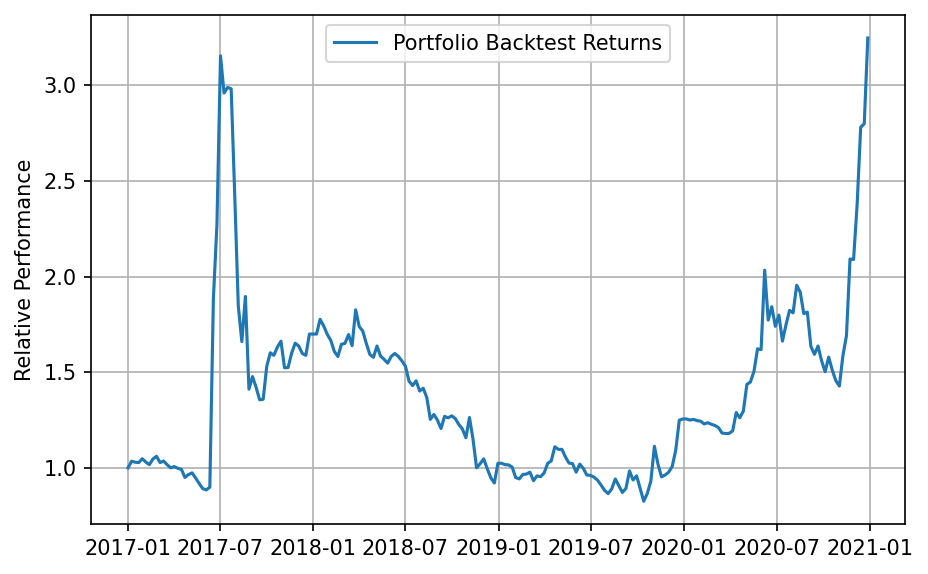

time: 156 ms (started: 2022-10-13 17:45:57 +08:00)


In [25]:
plt.plot(backTest)
plt.grid()
plt.legend(['Portfolio Backtest Returns'])
plt.ylabel('Relative Performance');

## Test for a particular year, say in 2020

In [26]:
# df_y_test is just y_test put in a dataframe (with actual returns)
df_y_test = getYPerf(y_test_withdata)

# Create a boolean mask for the backtest year we are interested in
# In this case, we are interested in the year 2020.
myDate = pd.to_datetime('2020-01-01')
mask2020 = y_test_withdata["Date1"].between(pd.to_datetime(myDate)-pd.Timedelta(days=60),
                                            pd.to_datetime(myDate)+pd.Timedelta(days=60))

time: 0 ns (started: 2022-10-13 17:45:58 +08:00)


In [27]:
df_y_test.head()

,Ticker,Perf
26780,TXT,0.393306
16361,MC,0.044954
27115,UNH,0.003878
18629,NLST,-0.825243
258,ABT,0.473658


time: 0 ns (started: 2022-10-13 17:45:58 +08:00)


In [28]:
X_test[mask2020]

,CR,Acid,CashRatio,InvTO,AssetTurnover,NWC_TO,PM,GPM,ROE,ROCE,...,EV_EBIT,DE,DebtRatio,ICR,Equity_Liab,WorkingCap,OI_NWCFA,WC_TA,RE_TA,EBIT_TA
12427,2.753433,2.398863,0.982609,0.000000,0.139303,0.835930,0.049792,0.350322,0.007698,0.007535,...,121.369502,0.469364,3.130544,6.970921,2.130544,2.753433,0.005262,0.125874,0.627622,0.006994
17197,1.545665,1.538732,1.223083,4.731161,-3.439816,0.000000,0.152515,0.913615,-0.070142,-0.039677,...,-41.960743,3.119461,1.320568,-14.968116,0.320568,1.545665,-0.293833,0.160453,-0.901888,-0.028010
8224,1.488171,1.488171,0.435396,0.000000,0.867973,3.755825,0.000000,0.173945,-0.132660,-0.026607,...,-32.091014,7.223504,1.138437,0.294118,0.138437,1.488171,0.006123,0.094073,-0.318604,-0.021480
7734,0.551710,0.537847,0.073456,0.000000,1.166042,0.000000,0.163033,0.416081,-0.134423,0.055029,...,71.332454,0.000000,0.769298,7.440616,-0.230702,0.551710,0.484921,-0.093070,-0.411389,0.043605
19211,1.380121,0.840833,0.117193,0.000000,2.271861,2.318021,0.302591,0.324695,0.158927,0.000237,...,500.000000,2.130905,1.469284,3.028571,0.469284,1.380121,0.092698,0.072369,-0.153689,0.000192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21236,5.589894,5.277438,4.966170,0.000000,0.149800,0.303616,0.000000,0.872565,-0.010090,-0.012839,...,-99.745116,0.205460,5.867121,-5.648214,4.867121,5.589894,-0.010086,0.307844,0.366952,-0.011978
29149,13.481437,13.481437,10.000000,0.000000,5.774809,0.094439,0.000000,0.000000,-0.052450,-0.027300,...,-181.020854,0.123321,9.108894,2.389408,8.108894,13.481437,-0.060424,0.824991,-1.408989,-0.025496
26847,0.548534,0.476771,0.330968,0.000000,0.360888,0.000000,0.058872,0.378306,0.055589,0.018926,...,52.944258,3.562570,1.280696,7.564885,0.280696,0.548534,0.042303,-0.128186,0.184676,0.013552
17349,1.825329,1.825329,1.345366,0.000000,11.101299,1.584136,0.039307,0.256434,0.085714,0.057419,...,27.172129,2.462755,1.406049,12.100000,0.406049,1.825329,0.078495,0.397525,0.262413,0.029763


time: 16 ms (started: 2022-10-13 17:45:58 +08:00)


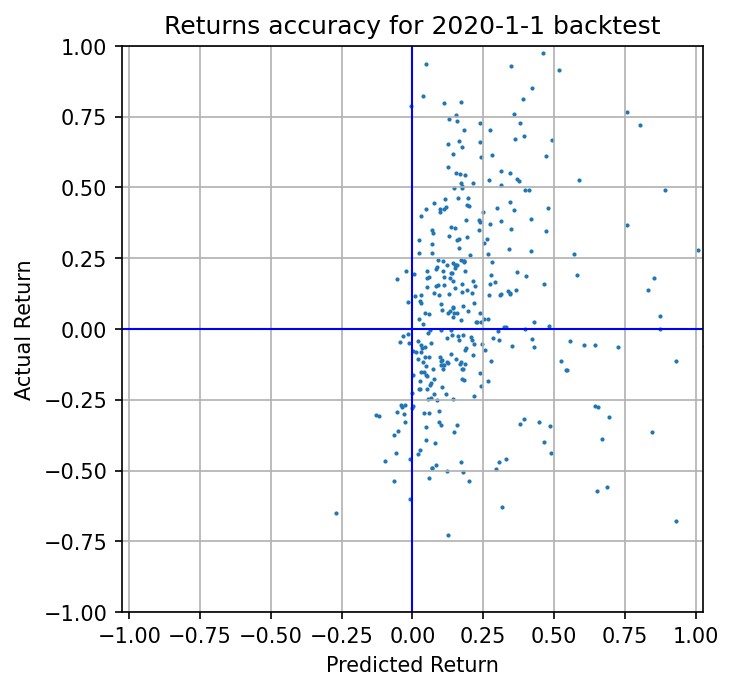

time: 156 ms (started: 2022-10-13 18:04:33 +08:00)


In [48]:
# Load the model pipeline
ml_model_pipeline = pickle.load(open("rf_tuned.p", "rb" ))

# Get stock performance predictions
y_pred = ml_model_pipeline.predict(X_test[mask2020])
y_pred = pd.DataFrame(y_pred) # Turn into DataFrame

# Now output scatter graph to see prediction/actual for that year only.
plt.figure(figsize=(5,5))
plt.scatter(y_pred[0], df_y_test[mask2020]["Perf"], s=1)

# Formatting
plt.grid()
plt.axis('equal')
plt.title('Returns accuracy for {}-{}-{} backtest'.format(myDate.year, myDate.month, myDate.day))
plt.xlabel('Predicted Return')
plt.ylabel('Actual Return')
plt.axvline(c='blue', lw=1)
plt.axhline(c='blue', lw=1)
plt.axis([-1,1,-1,1]);

In [49]:
df_y_test

,Ticker,Perf
26780,TXT,0.393306
16361,MC,0.044954
27115,UNH,0.003878
18629,NLST,-0.825243
258,ABT,0.473658
...,...,...
22,AA,-0.490529
25249,T,-0.141506
5903,CMI,0.081549
19675,OMP,-0.516069


time: 0 ns (started: 2022-10-13 18:04:59 +08:00)


In [50]:
# Top stocks picked for 2020, and predicted performance
# bestStocks_2020 is a mask
bestStocks_2020 = (y_pred[0] > y_pred.nlargest(11,0).tail(1)[0].values[0])

print("\nTop predicted stocks picked:")
print(df_y_test[mask2020].reset_index(drop=True)[bestStocks_2020]["Ticker"])

print("\nPredicted performance is:")
print(y_pred[bestStocks_2020])

print("\nActual performance was: ")
print(df_y_test[mask2020].reset_index(drop=True)[bestStocks_2020])


Top predicted stocks picked:
23     BOXL
34      CGA
70      MIK
115    CRIS
122    UNIT
171    NURO
186    STRR
202    XBIT
263    LXRX
308    SESN
Name: Ticker, dtype: object

Predicted performance is:
            0
23   1.480484
34   1.794685
70   1.444202
115  4.973912
122  1.731576
171  1.789433
186  1.475387
202  1.174235
263  1.350849
308  1.898582

Actual performance was: 
    Ticker      Perf
23    BOXL  0.283186
34     CGA -0.096429
70     MIK  2.102362
115   CRIS  3.840764
122   UNIT  0.473485
171   NURO -0.326613
186   STRR  0.063433
202   XBIT -0.194997
263   LXRX -0.186893
308   SESN  0.238095
time: 0 ns (started: 2022-10-13 18:05:05 +08:00)


In [51]:
# See what the performance is of the selection
print("Backtest return is:")
print(df_y_test[mask2020]["Perf"].reset_index(drop=True)[bestStocks_2020].values.mean())

Backtest return is:
0.6196393172828286
time: 0 ns (started: 2022-10-13 18:05:09 +08:00)


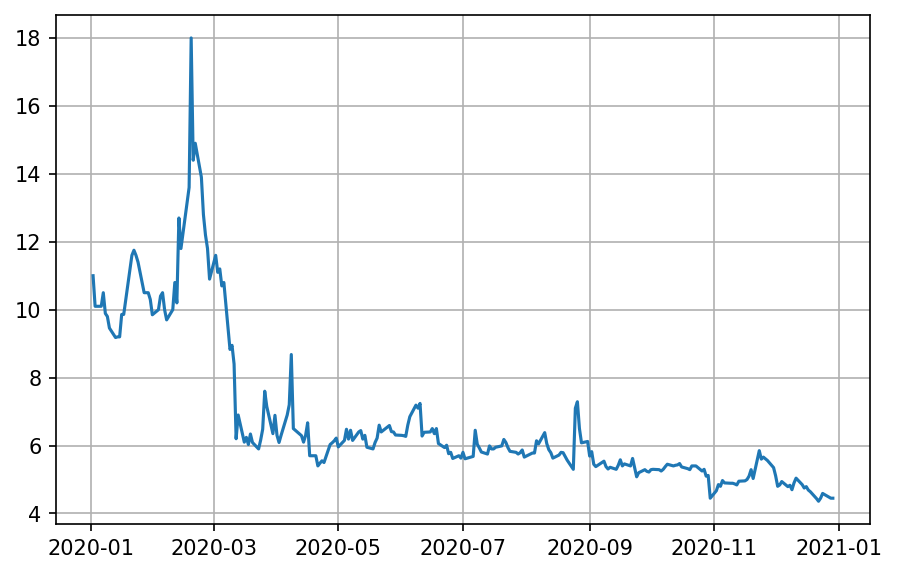

time: 297 ms (started: 2022-10-13 18:05:10 +08:00)


In [52]:
# Look at stock price of one of the companies (one of the bigger losers)
rows = getStockPriceData("VIVE", y_test_withdata, mask2020, df_prices)

plt.plot(rows["Date"], rows["Close"]) # Adj. Close
plt.grid(True)

['BOXL' 'CGA' 'MIK' 'CRIS' 'UNIT' 'NURO' 'STRR' 'XBIT' 'LXRX' 'SESN']


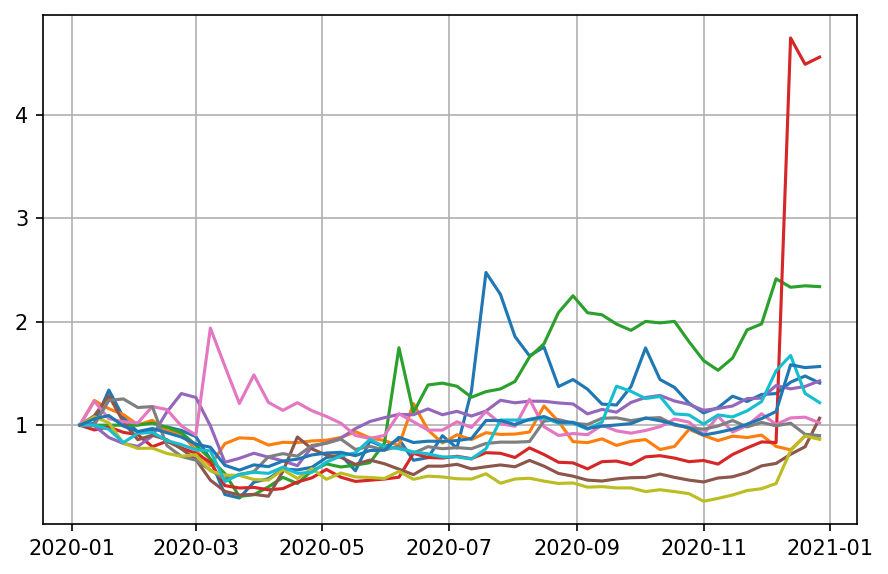

time: 3.38 s (started: 2022-10-13 18:05:18 +08:00)


In [53]:
# Want to find the performance for each selected stock

#DatetimeIndex
date_range = pd.date_range(start=myDate, periods=52, freq='W')

# 10 greatest performance stocks of y_pred 
ticker_list = y_test_withdata[mask2020].reset_index(drop=True)[bestStocks_2020]["Ticker"].values
ticker_list = y_test_withdata[mask2020].reset_index(drop=True)[bestStocks_2020]["Ticker"].values
print(ticker_list)

stockRet = getStockTimeSeries(date_range, y_test_withdata, ticker_list, mask2020, df_prices)

stockRetRel = getPortfolioRelativeTimeSeries(stockRet)

stockRetRel.head()

plt.plot(stockRetRel)
plt.grid();

# S&P 500 historical data

In [35]:
spy = pd.read_csv("S&P500.csv", index_col='Date', parse_dates=True).sort_index()

time: 46 ms (started: 2022-10-13 17:46:01 +08:00)


In [36]:
spy = spy.apply(lambda x: x.str.replace(',', ''))
spy = spy.astype(float)

time: 16 ms (started: 2022-10-13 17:46:01 +08:00)


In [37]:
spy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 320 entries, 2016-08-29 to 2022-10-07
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Open         320 non-null    float64
 1   High         320 non-null    float64
 2   Low          320 non-null    float64
 3   Close*       320 non-null    float64
 4   Adj Close**  320 non-null    float64
 5   Volume       320 non-null    float64
dtypes: float64(6)
memory usage: 17.5 KB
time: 16 ms (started: 2022-10-13 17:46:01 +08:00)


In [38]:
# We only want the SPY data between start 2017 to end 2020
spy = spy.loc[(spy.index>='2017-01-01') & (spy.index<'2020-12-31')]

time: 0 ns (started: 2022-10-13 17:46:01 +08:00)


In [39]:
spy

,Open,High,Low,Close*,Adj Close**,Volume
Date,,,,,,
2017-01-02,2251.57,2282.10,2245.13,2276.98,2276.98,1.463713e+10
2017-01-09,2273.59,2279.27,2254.25,2274.64,2274.64,1.702021e+10
2017-01-16,2269.14,2276.96,2258.41,2271.31,2271.31,1.359118e+10
2017-01-23,2267.78,2300.99,2257.02,2294.69,2294.69,1.755594e+10
2017-01-30,2286.01,2298.31,2267.21,2297.42,2297.42,1.900101e+10
...,...,...,...,...,...,...
2020-11-30,3634.18,3699.20,3594.39,3699.12,3699.12,2.690281e+10
2020-12-07,3694.73,3712.39,3633.40,3663.46,3663.46,2.353356e+10
2020-12-14,3675.27,3726.70,3645.84,3709.41,3709.41,2.426542e+10


time: 16 ms (started: 2022-10-13 17:46:01 +08:00)


In [40]:
# To index 2017 start date as 1 to find cumulative returns
spy['Relative'] = spy["Open"]/spy["Open"][0]
spy

,Open,High,Low,Close*,Adj Close**,Volume,Relative
Date,,,,,,,
2017-01-02,2251.57,2282.10,2245.13,2276.98,2276.98,1.463713e+10,1.000000
2017-01-09,2273.59,2279.27,2254.25,2274.64,2274.64,1.702021e+10,1.009780
2017-01-16,2269.14,2276.96,2258.41,2271.31,2271.31,1.359118e+10,1.007803
2017-01-23,2267.78,2300.99,2257.02,2294.69,2294.69,1.755594e+10,1.007199
2017-01-30,2286.01,2298.31,2267.21,2297.42,2297.42,1.900101e+10,1.015296
...,...,...,...,...,...,...,...
2020-11-30,3634.18,3699.20,3594.39,3699.12,3699.12,2.690281e+10,1.614065
2020-12-07,3694.73,3712.39,3633.40,3663.46,3663.46,2.353356e+10,1.640957
2020-12-14,3675.27,3726.70,3645.84,3709.41,3709.41,2.426542e+10,1.632314


time: 16 ms (started: 2022-10-13 17:46:02 +08:00)


Volatility of AI investor was:  1.0516472507242283
Volatility of S&P 500 was:  0.23172422345963195


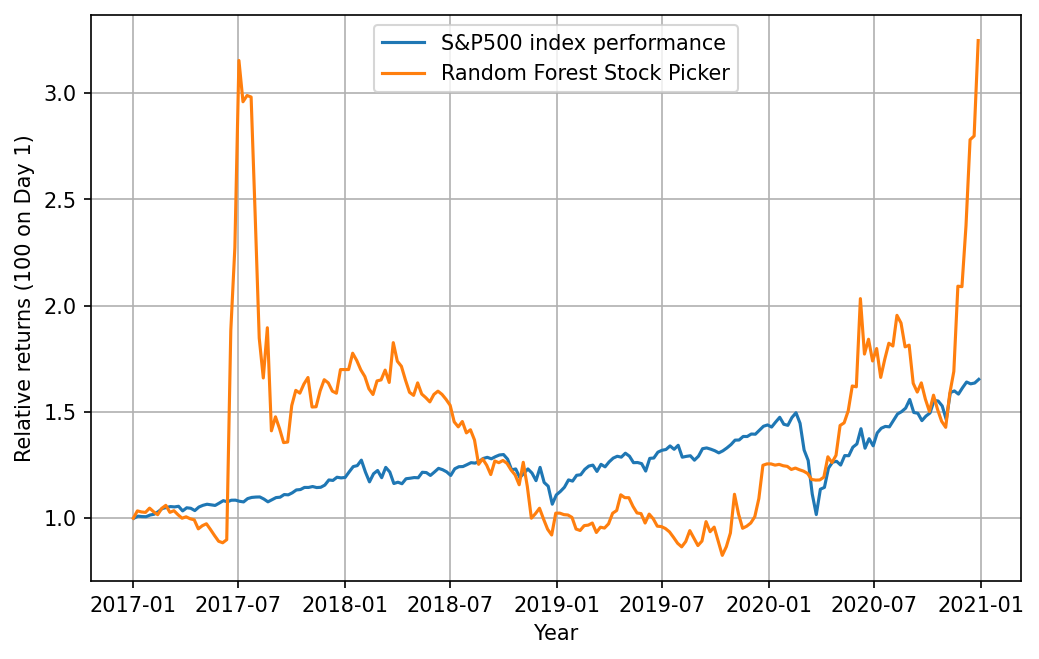

time: 172 ms (started: 2022-10-13 18:06:08 +08:00)


In [54]:
plt.figure(figsize=(8,5))

# Plot the S&P relative performance from Day 1
plt.plot(spy['Relative'])

# Plot the portfolio backtest performance
plt.plot(backTest)

plt.grid()
plt.xlabel('Year')
plt.ylabel('Relative returns (100 on Day 1)')
plt.legend(['S&P500 index performance', 'Random Forest Stock Picker'])

print('Volatility of AI investor was: ', backTest['Indexed Performance'].diff().std()*np.sqrt(52))
print('Volatility of S&P 500 was: ', spy["Relative"].diff().std()*np.sqrt(52))

# Account for chance of default using Altman Z-score

Z = 3.25 + 6.51 X1 + 3.26 X2 + 6.72 X3 + 1.05 X4

The lower the Z score, the higher the risk of default. A Z score of 4 is roughly equivalent to B credit rating (about 5% risk of default). We use the following guidelines to determine which companies to choose:
- Z > 2.99: Non-bankrupt zone
- 1.81 < Z < 2.99: Grey zone
- Z < 1.81: Distress zone

In [42]:
# Top stocks picked for 2020, and predicted performance
# bestStocks_2020 is a mask
bestStocks_2020 = (y_pred[0] > y_pred.nlargest(11,0).tail(1)[0].values[0])

print("\nTop predicted stocks picked:")
print(df_y_test[mask2020].reset_index(drop=True)[bestStocks_2020]["Ticker"])

print("\nPredicted performance is:")
print(y_pred[bestStocks_2020])

print("\nActual performance was: ")
print(df_y_test[mask2020].reset_index(drop=True)[bestStocks_2020])

# Calculate Altman Z score.
# To give a sense of the risk of default
Z = 3.25 \
+ 6.51 * X_test[mask2020].reset_index(drop=True)[bestStocks_2020]['WC_TA']\
+ 3.26 * X_test[mask2020].reset_index(drop=True)[bestStocks_2020]['RE_TA']\
+ 6.72 * X_test[mask2020].reset_index(drop=True)[bestStocks_2020]['EBIT_TA']\
+ 1.05 * X_test[mask2020].reset_index(drop=True)[bestStocks_2020]['Equity_Liab']
print('\nZ scores:\n')
print(Z)


Top predicted stocks picked:
34      CGA
70      MIK
115    CRIS
139     ALT
154    MARA
172    CRDF
186    STRR
215    CELH
267      DS
269     VGR
Name: Ticker, dtype: object

Predicted performance is:
            0
34   1.264709
70   1.265800
115  3.216392
139  2.113981
154  4.784830
172  3.647305
186  1.822138
215  3.145028
267  1.277291
269  1.391885

Actual performance was: 
    Ticker       Perf
34     CGA  -0.096429
70     MIK   2.102362
115   CRIS   3.840764
139    ALT   5.387640
154   MARA  13.604651
172   CRDF  13.120968
186   STRR   0.063433
215   CELH   7.377823
267     DS  -0.362398
269    VGR  -0.112453

Z scores:

34     14.136435
70      2.777097
115   -60.670802
139     4.350192
154   -49.001648
172   -46.345106
186    -1.255745
215     5.130277
267   -17.123433
269     2.269693
dtype: float64
time: 16 ms (started: 2022-10-13 17:46:02 +08:00)


The top 2 performing stocks which returned 13x actually had the worst Z-scores!